# UN General Assembly Resolutions

This notebook draws from a dataset of UN Member States' historical voting records on General Assembly resolutions from 1946 to 2023, and displays preliminary explorations into relationships and trends exhibited by the Member States.

Voting records were sourced from the UN Digital Library (Dag Hammarskjöld Library). Some earlier records on the database do not disclose breakdowns of Members States' voting behaviour. From a starting point of 7,070 resolutions passed by the UN General Assembly (UNGA) between 1946 and 2023 (inclusive), a total of 1,660 from between 1946 and 1982 do not reveal the individual voting records.

Of the 5,410 records that do provide breakdowns by country, 8 records from 2023 are absent from this dataset, leaving a total of 5,402 included in the dataset examined here.

## Data collection

Data collection for this dataset is undertaken via the the `src/segments.py` and `src/records.py` files within this project, which retrieved links to records and then the records themselves from the UN Digital Library.

These files have been written such that the records and dataset may be updated with new resolution vote records that result from future UNGA sessions.

The retrieval process generates CSV and text files inside the project's `src/data` folder as follows, each of which is timestamped to retain previous versions:
- `"{YYYYMMDD_HHMM}_links.csv"`: generated by `src/segments.py`, this is a list of the URL link segments for each UNGA resolution.
- `"{YYYYMMDD_HHMM}_processed_segments.txt"`: generated by `src/records.py`, this keeps track of which resolution records have previously been processed.
- `"{YYYYMMDD_HHMM}_records.csv"`: generated by `src/records.py`, this is the full UNGA resolution dataset, with basic pre-processing applied to split and sort data for further processing.e

## Data pre-processing

The majority of data pre-processing for this project's dataset is undertaken via the `src/preprocessing.py` file.

Some initial pre-processing takes place in `src/records.py`, in the form of converting the raw data to strings or integers, sorting countries within vote lists, and arranging columns for further processing.

More involved processing then takes place in `src/preprocessing.py`, which expands the vote records for each resolution to populate columns for each individual Member State, and consolidates Member States based on the conditions desribed in `README.md`. It is also at this stage that resolution dates are converted to a unified format, and that resolutions are sorted by date and then reference number.

The `src/preprocessing.py` file also drops certain columns, which are retained in the `"YYYYMMDD_HHMM_records.csv"` files in case of future requirement, but are not necessary for this project. The "Record URL" and "Segment" columns are added during the retrieval process, and record the full URL and URL segment of each resolution. The "Meeting Record", "Draft Resolution", "Committee Report", and "Note" columns come from the raw data, but are not required for this exercise.

The pre-processing stage generates the following file:
- `"{YYYYMMDD_HHMM}_UNGA_votes.csv"`: generated by `src/preprocessing.py`, this is the dataset output that results from the retrieval and preprocessing stages described above.

## Dataset overview

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
# Set plot scheme
palette = {"dark": "#252b33", "grey": "#45464d", "light": "#fefeff", "stone": "#8f8f94", 
           "blue": "#336681", "green": "#089389", "red": "#d34748", "pink": "#cf82d3", "yellow": "#e6daaa"
}
# Set plot defaults
sns.set_style(rc={"figure.facecolor": palette["dark"],
                  "axes.facecolor": palette["dark"],
                  "axes.edgecolor": palette["light"],
                  "grid.color": palette["grey"]})

In [3]:
df = pd.read_csv("./data/20240104_1523_UNGA_votes.csv", low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5402 entries, 0 to 5401
Columns: 211 entries, Resolution to ZIMBABWE
dtypes: int64(5), object(206)
memory usage: 8.7+ MB


In [5]:
df.shape

(5402, 211)

This is a large dataset, consisting of 5,402 rows (UNGA resolution records) and 211 columns.

The initial dataset is too large to conveniently display in this notebook, so we will begin by reviewing the first 12 columns; these contain the main details for the resolutions.

### Dataset overview - UNGA Resolution details

In [6]:
pd.concat([df.head(1), df.tail(1)]).iloc[:, :12]

,Resolution,Vote Date,Num Yes,Num No,Num Abstentions,Num Non-Voting,Total Votes,Title,Yes Votes,No Votes,Abstentions,Non-Voting
0,A/RES/17(I)[RULE-73],1946-01-26,25,18,0,8,51,Amendments to the provisional rules of procedu...,"['ARGENTINA', 'BELGIUM', 'BOLIVIA', 'BRAZIL', ...","['AUSTRALIA', 'BELARUS', 'CANADA', 'CHILE', 'C...",[],"['EL SALVADOR', 'ETHIOPIA', 'GREECE', 'GUATEMA..."
5401,A/RES/78/251,2023-12-22,137,2,22,32,193,Proposed programme budget for 2024 : Section 2...,"['ALGERIA', 'ANGOLA', 'ARGENTINA', 'ARMENIA', ...","['AUSTRALIA', 'ISRAEL']","['ALBANIA', 'ANDORRA', 'CAMEROON', 'CANADA', '...","['AFGHANISTAN', 'ANTIGUA AND BARBUDA', 'BELIZE..."


In [7]:
resolution_details_df = df.iloc[:, :12]
resolution_details_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5402 entries, 0 to 5401
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Resolution       5402 non-null   object
 1   Vote Date        5402 non-null   object
 2   Num Yes          5402 non-null   int64 
 3   Num No           5402 non-null   int64 
 4   Num Abstentions  5402 non-null   int64 
 5   Num Non-Voting   5402 non-null   int64 
 6   Total Votes      5402 non-null   int64 
 7   Title            5402 non-null   object
 8   Yes Votes        5402 non-null   object
 9   No Votes         5402 non-null   object
 10  Abstentions      5402 non-null   object
 11  Non-Voting       5402 non-null   object
dtypes: int64(5), object(7)
memory usage: 506.6+ KB


A read-out of the first 12 columns of the first and last entries of the dataset is printed above, followed by information on the 12 columns.

The dataset is date-sorted (as described earlier) and contains resolution records from 26 January 1946 to 22 December 2023.

The columns are as follows:
- Resolution: the reference number of the resolution
- Vote Date: the date of the resolution, in YYYY-MM-DD format
- Num Yes: the number of UN Member States that voted in favour of the resolution
- Num No: the number of UN Member States that voted against the resolution
- Num Abstentions: the number of UN Member States that abstained from voting on the resolution
- Num Non-Voting: the number of UN Member States that were not eligible to vote on the resolution
- Total Votes: the sum total of the Num Yes, Num No, Num Abstentions, and Num Non-Voting figures
- Title: the title of the resolution
- Yes Votes: the list of UN Member States that voted in favour of the resolution
- No Votes: the list of UN Member States that voted in favour of the resolution
- Abstentions: the list of UN Member States that abstained from voting on the resolution
- Non-Voting: the list of UN Member States that were not eligible to vote on the resolution

Before proceeding, we can convert the Vote Date column to datetime format in the original dataframe.

In [8]:
df["Vote Date"] = pd.to_datetime(df["Vote Date"], format="%Y-%m-%d")
resolution_details_df = df.iloc[:, :12]
resolution_details_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5402 entries, 0 to 5401
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Resolution       5402 non-null   object        
 1   Vote Date        5402 non-null   datetime64[ns]
 2   Num Yes          5402 non-null   int64         
 3   Num No           5402 non-null   int64         
 4   Num Abstentions  5402 non-null   int64         
 5   Num Non-Voting   5402 non-null   int64         
 6   Total Votes      5402 non-null   int64         
 7   Title            5402 non-null   object        
 8   Yes Votes        5402 non-null   object        
 9   No Votes         5402 non-null   object        
 10  Abstentions      5402 non-null   object        
 11  Non-Voting       5402 non-null   object        
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 506.6+ KB


#### Note on vote figures

To become a UNGA resolution, a draft resolution must receive a majority of Yes votes in order to pass. Under current rules this "majority" is typically 50% of Yes and No votes plus one vote, but in some circumstances a two-thirds majority may be required.

This dataset is compiled from UNGA resolutions, and so naturally the number of Yes votes must exceed the No votes, Abstentions, and Non-Voting entries. As subset below shows, there are no resolution entries for which the number of Yes votes is less than or equal to 50% of the number of Yes and No votes combined.

In [9]:
df[df["Num Yes"] / (df["Num Yes"] + df["Num No"]) <= 0.5]

,Resolution,Vote Date,Num Yes,Num No,Num Abstentions,Num Non-Voting,Total Votes,Title,Yes Votes,No Votes,...,URUGUAY,UZBEKISTAN,VANUATU,VENEZUELA,VIETNAM,YEMEN,YEMEN (PDR),YUGOSLAVIA,ZAMBIA,ZIMBABWE


### Dataset overview - UN Member State columns

The original UN records contain the UNGA voting records of 255 current and former Member States.

Those 255 entities are consolidated down to 199 via the process described in this project's `README.md` file, typically by merging Member States that are the same entity but have changed their official names, but also by assessing political changes that have resulted in the merger or dissolution of Member States.

See `README.md` for further details of the vote record consolidation.

Of the 199 consolidated entities referred to above, 193 are current Member States as of January 2024. The former Member States for whcih is has not been possible to align their records with current Member States are Czechoslovakia, East Germany, Federation of Malaya, Serbia and Montenegro, Yemen (PDR), and Yugoslavia.

The records for those entities feature significant gaps prior to and/or following their tenure as Member States; this is true also of those Member States that acceeded to the UN subsequent to its establishment. South Sudan, the most recent entry to the UNGA, joined in 2011, and has votes recorded for just 1,097 (20.3%) of the 5,402 resolutions mentioned above.

In [10]:
df["AFGHANISTAN"].unique()

array([nan, 'Y', 'A', 'X', 'N'], dtype=object)

Each record under the 199 country columns contains one of five possible values, as follows:

|Symbol|Description|
|---|---|
|Y|"Yes" vote|
|N|"No" vote|
|A|Abstention|
|X|Non-Voting|
|N/A|No record|

Note that Abstention differs from Non-Voting in that the former indicates a Member State chose not to vote on a given resolution, whereas Non-Voting indicates that a Member State was not eligible to vote on a resolution. N/A is entered for resolutions passed at a time during which the country did not hold Member State status.

## EDA

A range of divergent use-cases could be applied to this dataset, for instance to hone in on Member States' stances towards climate change, geopolitical issues, or similarities and differences between selected entities that might provide insight into foreign policy agendas over time.

Governments take UNGA resolutions seriously, and they are the subject of significant diplomatic negotiations between Member States. Analysis of prior vote behaviour could therefore be informative for lobbying efforts by government departments, think tanks, policy analysts, or organisations and individuals with interests in a particular field.

Here we will take a few different approaches to the dataset, to get a sense of how it might be useful to political analysts or researchers interested in specific subject-matter. 

### Example 1: Switzerland

Switzerland acceeded to the UN in 2002, making it one of the most recent countries to do so. It has a population of approximately 8.9 million people [as of 2023](https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung.gnpdetail.2023-0208.html), and four official languages: French, German, Italian, and Romansh.

According to Switzerland's [Federal Statistical Office](https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/sprachen-religionen.assetdetail.24205499.html), the percentage of the population that spoke these languages as their mother tongue in 2000 and 2021 - which roughly covers the period from Switzerland's UN accession to the present - were as follows:

|Language|2000|2021|
|---|---|---|
|German|64.2%|62.0%|
|French|20.0%|22.7%|
|Italian|6.8%|8.2%|
|Romansh|0.5%|0.5%|

As a basic example, we can examine whether Switzerland's language demographics correlate with any affinity to fellow UN Member States Germany, France, and Italy, in terms of voting behaviour at the General Assembly.

#### Switzerland - Drop missing values

First, drop records prior to Switzerland's accession:

In [11]:
swiss_df = df[df["SWITZERLAND"].notna()]

In [12]:
swiss_df.shape

(1797, 211)

#### Switzerland - Drop unused features

We are interested only in the voting records for Switzerland, France, Germany, and Italy, so can drop all other country columns. We can also keep just the resolution reference numbers and vote dates, because the number of votes per resolution is not relevant.

In [13]:
columns = ["Resolution", "Vote Date", "FRANCE", "GERMANY", "ITALY", "SWITZERLAND"]
swiss_df = swiss_df[columns]
swiss_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1797 entries, 3605 to 5401
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Resolution   1797 non-null   object        
 1   Vote Date    1797 non-null   datetime64[ns]
 2   FRANCE       1797 non-null   object        
 3   GERMANY      1797 non-null   object        
 4   ITALY        1797 non-null   object        
 5   SWITZERLAND  1797 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 98.3+ KB


#### Switzerland - Transform features

We are interested in whether France, Germany, or Italy voted in the same way as Switzerland, rather than how they voted (Yes, No, Abstention, or Non-Voting).

We can therefore assign a value of 1 to indicate that a vote matched Switzerland's, and 0 otherwise.

In [14]:
swiss_df["FR"] = np.where(swiss_df["FRANCE"]==swiss_df["SWITZERLAND"], 1, 0)
swiss_df["DE"] = np.where(swiss_df["GERMANY"]==swiss_df["SWITZERLAND"], 1, 0)
swiss_df["IT"] = np.where(swiss_df["ITALY"]==swiss_df["SWITZERLAND"], 1, 0)
swiss_df["CH"] = 1

#### Switzerland - Plot data

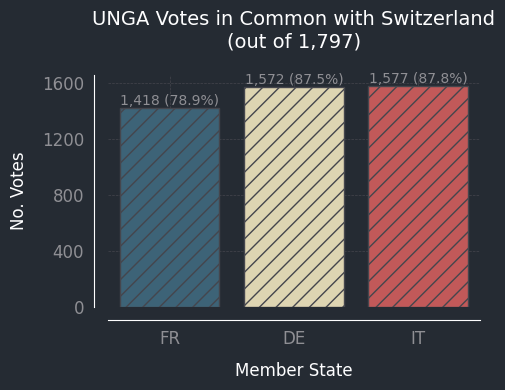

In [15]:
# Set up matplotlib figure
fig, ax = plt.subplots(figsize=(5, 4))
# Calculate column sums
column_sums = swiss_df[["FR", "DE", "IT"]].sum()
# Calculate total number of records
total_votes = len(swiss_df)
# Set bar colours
colours = [palette["blue"], palette["yellow"], palette["red"]]
# Plot barplot
for col, colour in zip(column_sums.index, colours):
    bar = sns.barplot(x=[col], y=[column_sums[col]], hatch="//", color=colour, ec=palette["grey"], zorder=3)
# Remove top and right axes
sns.despine(offset=10)
# Remove ticks from x and y axes (left and bottom)
ax.tick_params(left=False, bottom=False)
# Set descriptors
bar.set_title(f"UNGA Votes in Common with Switzerland\n(out of {total_votes:,})",
              fontdict={"size": 14, "color": palette["light"]}, pad=20)
bar.set_xlabel("Member State", fontdict={"size": 12, "color": palette["light"]}, labelpad=10)
bar.set_ylabel("No. Votes", fontdict={"size": 12, "color": palette["light"]}, labelpad=10, rotation=90)
plt.xticks(fontsize=12, color=palette["stone"])
plt.yticks(fontsize=12, color=palette["stone"])
ax.set_yticks([0, 400, 800, 1200, 1600])
# Show major gridlines
ax.grid(True,
        color=palette["grey"],
        linestyle="--",
        linewidth=0.5,
        zorder=0)
# Add text labels for vote counts
for bar in ax.patches:
    yval = bar.get_height()
    numerator = int(yval)
    denominator = total_votes
    ax.text(bar.get_x() + bar.get_width()/2,
            yval + 0.005,  # adjust height above bar
            f"{yval:,.0f} ({yval/total_votes:.1%})",  # display count and percent
            ha="center",
            va="bottom",
            color=palette["stone"],
            fontsize=10)

plt.tight_layout()
plt.show()

#### Switzerland - Summary

Eyeballing the figures in the chart above, we see that Switzerland's votes overlapped the most with Italy (87.8%), followed by Germany (87.5%), then France (78.9%). Clearly there is a strong correlation between the voting patterns of these countries with Switzerland, though comparing these statistics with the language demographics reviewed earlier (64% ~ 62% of Swiss are native German speakers; 20% ~ 22% are native French speakers; and 7% ~ 8% are native Italian speakers), we can be confident that language alone is a poor explainer for Switzerland's correlation with these three fellow Member States.

This has been a toy example to demonstrate a simple exploration of part of the dataset.

Next we can move on to more substantive examples.

### Example 2: Ngrams

As a further example, we can explore the frequency of UNGA resolution subject matters over time - in a similar manner to Google's [Ngram Viewer](https://books.google.com/ngrams/).

Two subjects that have featured prominently in UNGA discourse since the commencement of resolutions in 1946, are colonialism and the process of decolonisation; and nuclear arms and energy.

Plotting the occurrence of keywords over time provides an example of generating time series data from the dataset.

#### Ngrams - Drop unused features

We are interested in the Vote Date and Title columns here, so can retain those two columns and omit the rest of the dataset.

In [16]:
columns = ["Vote Date", "Title"]
ngrams_df = df[columns]
ngrams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5402 entries, 0 to 5401
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Vote Date  5402 non-null   datetime64[ns]
 1   Title      5402 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 84.5+ KB


#### Ngrams - Create and transform new features

To track subjects over time, we want to get counts per year of UNGA resolution titles that contain specified keywords.

For the subject of colonialism, we can count occurrences of titles containing the keyword "colon" to capture related terms "colonisation", "decolonisation", "colony", and so on.

For resolutions related to nuclear power and nuclear arms, we can track occurrences of titles that contain at least one of the terms "nuclear", "fission", "atomic", "hydrogen", and "uranium".

In [18]:
# Add binary column to capture resolutions with "colon" in the title
ngrams_df.loc[:, "Colonialism"] = np.where(ngrams_df["Title"].str.lower().str.contains("colon"), 1, 0)
# Create list of nuclear-related terms
nuclear_terms = ["nuclear", "fission", "atomic", "hydrogen", "uranium"]
# Add binary column to capture resolutions with nuclear-related terms in the title
ngrams_df.loc[:, "Nuclear"] = np.where(ngrams_df["Title"].str.lower().str.contains("|".join(nuclear_terms)), 1, 0)
# Get count of resolutions with "colon" in the title
colonial_count = ngrams_df.loc[:, "Colonialism"].sum()
# Get count of resolutions with nuclear-related terms in the title
nuclear_count = ngrams_df.loc[:, "Nuclear"].sum()
print(f"No. resolutions concerning:\n - colonialism-related issues: {colonial_count}\n - nuclear-related issues: {nuclear_count}")

No. resolutions concerning:
 - colonialism-related issues: 249
 - nuclear-related issues: 794


Of the 5,402 resolutions reviewed, 249 (4.6%) have colonialism-related terms in the title, and 794 (14.7%) have nuclear-related terms in the title.

Before plotting time series for these counts, note that the number of resolutions passed each year is not constant. To get a sense of shifting importance for a given issue, then, we should consider not only the count of related resolutions each year, but also the proportion of resolutions passed each year that relate to the issue concerned.

The graph below depicts the number of resolutions the UN General Assembly passed each year between 1946 and 2023.

In [19]:
# Get count of all UNGA resolutions passed per year
resolutions_per_year = ngrams_df.groupby(ngrams_df["Vote Date"].dt.year)["Vote Date"].count()

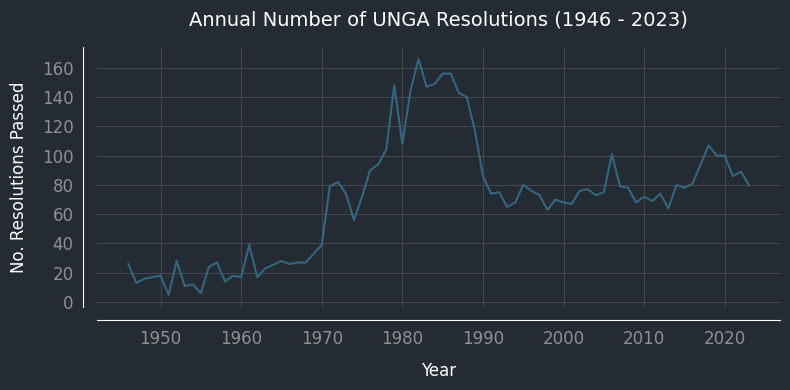

In [20]:
# Set up matplotlib figure
fig, ax = plt.subplots(figsize=(8, 4))
# Plot line chart
resolutions_per_year.plot(kind="line", linestyle="-", color=palette["blue"])
# Remove top and right axes
sns.despine(offset=10)
# Remove ticks from x and y axes (left and bottom)
ax.tick_params(left=False, bottom=False)
# Set descriptors
plt.title("Annual Number of UNGA Resolutions (1946 - 2023)", fontdict={"size": 14, "color": palette["light"]}, pad=16)
plt.xlabel("Year", fontdict={"size": 12, "color": palette["light"]}, labelpad=10)
plt.ylabel("No. Resolutions Passed", fontdict={"size": 12, "color": palette["light"]}, labelpad=10, rotation=90)
plt.xticks(fontsize=12, color=palette["stone"])
plt.yticks(fontsize=12, color=palette["stone"])

plt.grid()
plt.tight_layout()
plt.show()

We can see from the above chart that the average number of UNGA resolutions passed each year has shifted over time, with three distinct periods. 

From 1990 to the present, the average has fluctuated around 80 per year, but previous periods saw significantly fewer or significantly more resolutions passed.

We will group our term-related titles by year, and add columns to show the proportion of all resolutions they concern.

In [21]:
# Get count of colonialism-related UNGA resolutions passed per year
colonial_res_per_year = ngrams_df.groupby(ngrams_df["Vote Date"].dt.year)["Colonialism"].sum()
# Rename "Vote Date" as "Year"
colonial_res_per_year = colonial_res_per_year.reset_index().rename(columns={"Vote Date": "Year"})
# Get count of nuclear-related UNGA resolutions passed per year
nuclear_res_per_year = ngrams_df.groupby(ngrams_df["Vote Date"].dt.year)["Nuclear"].sum()
# Rename "Vote Date" as "Year"
nuclear_res_per_year = nuclear_res_per_year.reset_index().rename(columns={"Vote Date": "Year"})

In [22]:
# Create dataframe of UNGA resolutions per year
ngrams_timeseries = resolutions_per_year.to_frame().rename(columns={resolutions_per_year.name: "Total_Resolutions"})
# Reset index and rename "Vote Date" column as "Year"
ngrams_timeseries = ngrams_timeseries.reset_index().rename(columns={"Vote Date": "Year"})
# Merge term-related series as new columns
ngrams_timeseries = ngrams_timeseries.merge(colonial_res_per_year, on="Year", how="left")
ngrams_timeseries = ngrams_timeseries.merge(nuclear_res_per_year, on="Year", how="left")
# Reset index as year
ngrams_timeseries = ngrams_timeseries.set_index("Year")

In [23]:
ngrams_timeseries.head()

,Total_Resolutions,Colonialism,Nuclear
Year,,,
1946,26,0,0
1947,13,0,0
1948,16,0,0
1949,17,4,0
1950,18,0,1


In [24]:
ngrams_timeseries["Colonialism_Ratio"] = round(ngrams_timeseries["Colonialism"] / ngrams_timeseries["Total_Resolutions"], 3)
ngrams_timeseries["Nuclear_Ratio"] = round(ngrams_timeseries["Nuclear"] / ngrams_timeseries["Total_Resolutions"], 3)

In [25]:
ngrams_timeseries.tail()

,Total_Resolutions,Colonialism,Nuclear,Colonialism_Ratio,Nuclear_Ratio
Year,,,,,
2019,100,3,17,0.030,0.170
2020,100,4,16,0.040,0.160
2021,86,3,18,0.035,0.209
2022,89,3,16,0.034,0.180
2023,80,2,18,0.025,0.225


#### Ngrams - Plot data

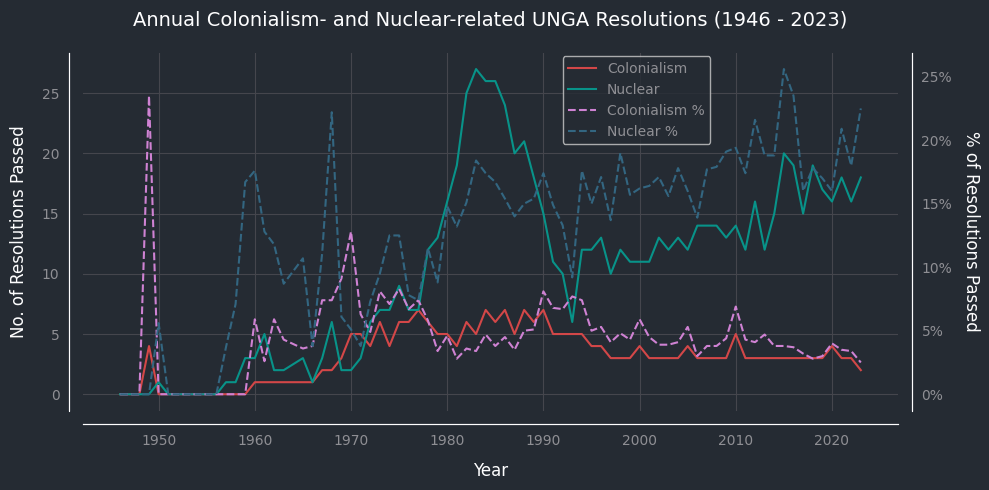

In [26]:
# Set up matplotlib figure
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot lines for Colonialism and Nuclear values on left y-axis
ngrams_timeseries["Colonialism"].plot(kind="line", linestyle="-", color=palette["red"], ax=ax1)
ngrams_timeseries["Nuclear"].plot(kind="line", linestyle="-", color=palette["green"], ax=ax1)

# Create second y-axis for percentage line plots 
ax2 = ax1.twinx()
# Plot line chart for Colonialism_Ratio and Nuclear_Ratio on the right y-axis (ax2)
ngrams_timeseries["Colonialism_Ratio"].plot(kind="line", linestyle="--", color=palette["pink"], ax=ax2, label="Colonialism %")
ngrams_timeseries["Nuclear_Ratio"].plot(kind="line", linestyle="--", color=palette["blue"], ax=ax2, label="Nuclear %")
# Remove ticks from x and y axes (left, right and bottom) for both axes
ax1.tick_params(left=False, bottom=False, right=False)
ax2.tick_params(left=False, bottom=False, right=False)

# Set descriptors for left y-axis
ax1.set_title("Annual Colonialism- and Nuclear-related UNGA Resolutions (1946 - 2023)", fontdict={"size": 14, "color": palette["light"]}, pad=20)
ax1.set_xlabel("Year", fontdict={"size": 12, "color": palette["light"]}, labelpad=10)
ax1.tick_params(axis="x", labelcolor=palette["stone"])
ax1.set_ylabel("No. of Resolutions Passed", fontdict={"size": 12, "color": palette["light"]}, labelpad=10, rotation=90)
ax1.tick_params(axis="y", labelcolor=palette["stone"])
# Show gridlines based on left y-axis (don"t repeat for right y-axis)
ax1.grid()
# Set descriptors for right y-axis
ax2.set_ylabel("% of Resolutions Passed", fontdict={"size": 12, "color": palette["light"]}, labelpad=20, rotation=270)
ax2.tick_params(axis="y", labelcolor=palette["stone"])

# Function to format right y-axis ticks as % using FuncFormatter
def percent_formatter(x, pos):
    return f"{x*100:.0f}%"
# Apply formatter to right y-axis ticks
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Set legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(.58, 1.01), loc="upper left")
# legend = ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
# Set legend text color
for text in legend.get_texts():
    text.set_color(palette["stone"])

# Remove top axis from figure
sns.despine(fig=fig, top=True, right=False, offset=10)
# Adjust layout and display the plot
plt.tight_layout()
plt.show()

The plot above gives the counts of UNGA resolutions passed each year that related to colonialism in red, and nuclear issues in green. We can see that the count for nuclear-related resolutions has followed an upward trend, with a surge during the 1980s, to a level that is now once again being approach in the 2020s.

The blue line plots the percentage share of resolutions passed each year that relate to nuclear issues - as the line shows, the situation is quite different to what the pure count in green would suggest: the share of resolutions that relate to nuclear issues has grown at a fairly constant rate over time.

The pink line shows that the percentage of resolutions related to colonialism has more closely mirrored its count-based counterpart in red, though there have been spikes such as in the late 1940s and late 1970s.

#### Ngrams - Summary

This exercise has demonstrated one means of observing trends in the data through the use of an Ngrams-style approach, but a range of approaches could be taken.

For example, the dataset could be used to examine how individual Member States' positions on certain issues have changed over time; or the relative positions of two or more Member States could be reviewed to observe how they have converged or diverged in foreign policy.

### Example 3: Member records

The UNGA dataset could be used to shed light on the vote records of individual countries. For example, to understand which countries are more likely to vote Yes or No, or abstain from voting altogther. This could be further coupled with Ngram-style analysis as above to obtain granular insight into a Member States' record across different fields.

In this example we will explore the records of South American Member States.

#### Member records - Drop unused features

We will review only the voting records of the 12 South American Member States, so can drop all other columns.

In [27]:
south_america = ["ARGENTINA", "BOLIVIA", "BRAZIL", "CHILE", "COLOMBIA", "ECUADOR", 
                 "GUYANA", "PARAGUAY", "PERU", "SURINAME", "URUGUAY", "VENEZUELA"] 
sa_df = df[south_america]

#### Member records - EDA

In [28]:
sa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5402 entries, 0 to 5401
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ARGENTINA  5402 non-null   object
 1   BOLIVIA    5402 non-null   object
 2   BRAZIL     5402 non-null   object
 3   CHILE      5402 non-null   object
 4   COLOMBIA   5402 non-null   object
 5   ECUADOR    5402 non-null   object
 6   GUYANA     5043 non-null   object
 7   PARAGUAY   5402 non-null   object
 8   PERU       5402 non-null   object
 9   SURINAME   4584 non-null   object
 10  URUGUAY    5402 non-null   object
 11  VENEZUELA  5402 non-null   object
dtypes: object(12)
memory usage: 506.6+ KB


10 of the 12 countries have been Member States since the UN was established, and have voting records for all resolutions in the dataset. Guyana became a Member State in 1966, and Suriname is the most recent Member State, having joined in 1975.

In [29]:
bolivia_votes = sa_df["BOLIVIA"].value_counts()
bolivia_votes

BOLIVIA
Y    4641
A     351
X     318
N      92
Name: count, dtype: int64

In [30]:
ecuador_votes = sa_df["ECUADOR"].value_counts()
paraguay_votes = sa_df["PARAGUAY"].value_counts()

#### Member records - Plot data

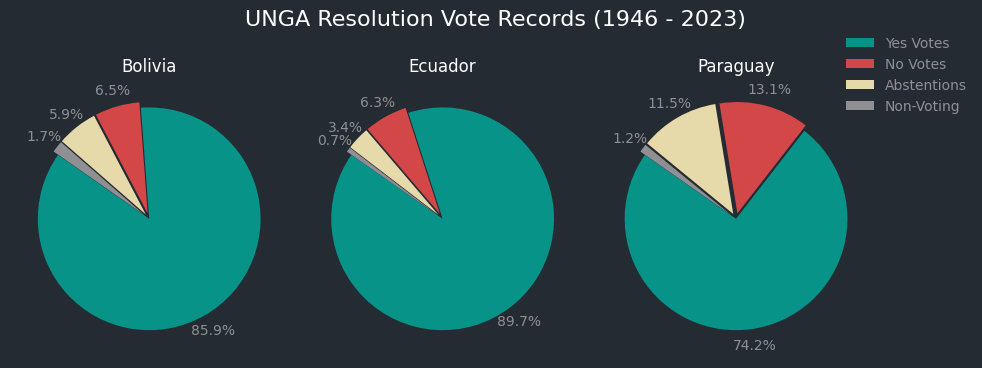

In [31]:
# Prepare data
data = [bolivia_votes, ecuador_votes, paraguay_votes]
members = ["Bolivia", "Ecuador", "Paraguay"]
# Set vote categories and labels
vote_categories = ["Y", "N", "A", "X"]
vote_descs = ["Yes Votes", "No Votes", "Abstentions", "Non-Voting"]
# Set colour palette
colours = [palette["green"], palette["red"], palette["yellow"], palette["stone"]]
# Plot pie chart
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
# Generate pie charts on each subplot
for i in range(len(data)):
    wedges, texts, autotexts = axes[i].pie(data[i], 
                                       labels=None, 
                                       autopct='%1.1f%%', 
                                       pctdistance=1.15,
                                       explode=(0, 0.05, 0.05, 0.05),
                                       colors=colours, 
                                       startangle=145, 
                                       textprops={"color": palette["stone"]})
    axes[i].set_title(members[i], fontsize=12, color=palette["light"])

# Set main title
fig.suptitle("UNGA Resolution Vote Records (1946 - 2023)", fontsize=16, color=palette["light"])

legend = plt.legend(wedges, vote_descs, loc="upper left", bbox_to_anchor=(0.85, 1.2), frameon=False)
# Set legend text color
for text in legend.get_texts():
    text.set_color(palette["stone"])
    
plt.tight_layout()
plt.show()

The above example shows the voting patterns for three UN Member States, Bolivia, Ecuador and Paraguay.

In [32]:
# Create dataframe with vote counts for each country
sa_counts_df = pd.DataFrame()
for column in sa_df.columns:
    vote_counts = sa_df[column].value_counts()
    sa_counts_df[column] = vote_counts
# Transpose to run country names down first column
sa_counts_df = sa_counts_df.transpose()
# Reset index and rename columns according to vote category
sa_counts_df.reset_index(inplace=True)
sa_counts_df.rename(columns={"index": "Country", "Y": "Y", "A": "A", "X": "X", "N": "N"}, inplace=True)
# Drop index name
sa_counts_df = sa_counts_df.rename_axis(None, axis=1)
# Re-order vote category columns
new_column_order = ["Country", "Y", "N", "A", "X"]
sa_counts_df = sa_counts_df[new_column_order]
sa_counts_df

,Country,Y,N,A,X
0,ARGENTINA,4558,55,727,62
1,BOLIVIA,4641,92,351,318
2,BRAZIL,4666,78,599,59
3,CHILE,4660,84,440,218
4,COLOMBIA,4697,34,511,160
5,ECUADOR,4846,37,338,181
6,GUYANA,4653,22,213,155
7,PARAGUAY,4009,65,621,707
8,PERU,4876,21,412,93
9,SURINAME,3892,12,231,449


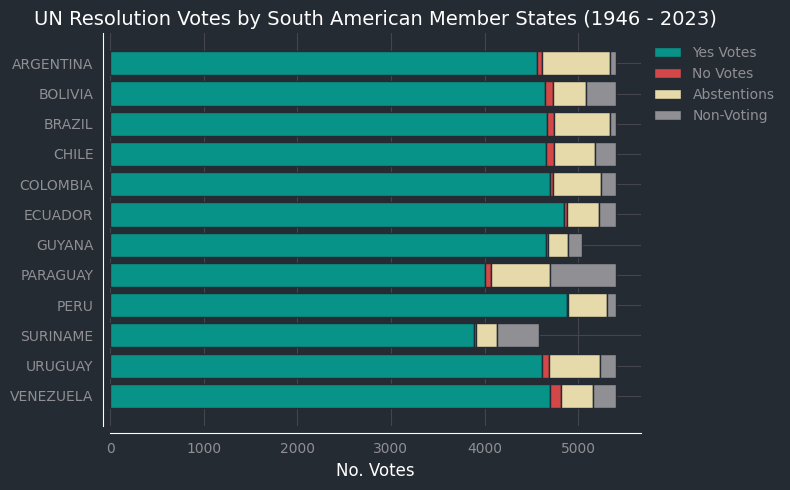

In [52]:
# Set vote categories and labels
vote_categories = ["Y", "N", "A", "X"]
vote_descs = ["Yes Votes", "No Votes", "Abstentions", "Non-Voting"]
# Set colour palette
colours = [palette["green"], palette["red"], palette["yellow"], palette["stone"]]
# Sort DataFrame by "Country" column in reverse order so it starts from ARGENTINA
sa_counts_df_sorted = sa_counts_df.sort_values(by="Country", ascending=False)

# Plot horizontal stacked bar chart using Seaborn
plt.figure(figsize=(8, 5))
# Initialise starting point for bars
base_values = [0] * len(sa_counts_df_sorted["Country"])

# Iterate through each category
for i, category in enumerate(vote_categories):
    plt.barh(sa_counts_df_sorted["Country"], 
             sa_counts_df_sorted[category], 
             color=colours[i], 
             edgecolor=palette["dark"], 
             label=vote_descs[i],
             height=0.8, 
             left=base_values, 
             zorder=3)
    # Set cumulative base values so that vote categories don't overlap
    base_values = [base + value for base, value in zip(base_values, sa_counts_df_sorted[category])]

# Set descriptors
plt.title("UN Resolution Votes by South American Member States (1946 - 2023)", fontsize=14, color=palette["light"])
plt.xlabel("No. Votes", fontsize=12, color=palette["light"])

# Remove top and right-hand spines
sns.despine(offset=5)
# Remove ticks from x and y axes (left and bottom)
plt.tick_params(left=False, bottom=False)
plt.yticks(color=palette["stone"])
plt.xticks(color=palette["stone"])

# Set legend without border line
legend = plt.legend(bbox_to_anchor=(1, 1), frameon=False)
# Set legend text color
for text in legend.get_texts():
    text.set_color(palette["stone"])

# Set gridlines zorder=0 to place behind bars
plt.grid(zorder=0)

plt.tight_layout()
plt.show()

This further example above shows stacked vote counts across categories for each of the South American UN Member States, this time displayed as stacked bar charts.

We can observe that Guyana and Suriname have shorter total bar lengths, which aligns with our earlier observation that these two countries acceeded to the UN later than the others, and have therefore been involved in fewer resolution votes.

Of the 10 countries that have been involved in all 5,402 resolutions in the dataset, Bolivia and Paraguay have been recorded as Non-Voting for more resolutions than their counterparts. A probable partial explanation for this is the fact that both a landlocked countries, and so may not have been eligible to cast votes on international maritime-related issues.

#### Member records - Summary

This example has provided sample analysis for the voting records of individual countries and groups of countries, with a focus on overall vote counts.

Further analysis could be undertaken to drill down on time series data for individual countries, and to observe vote records across specific subjects such as on global conflicts, climate change, and so on.